In [35]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

from preprocess import get_results, mean_aggregate_results

flat_map = lambda f, xs: reduce(lambda a, b: a + b, map(f, xs), [])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
ts = []
es = []
ls = []

for i in range(1, 16):
	t, e, l = get_results(f'../results_ultimate_{i}', frameworks={}, full=True, train_preserve_warmup=False) 
	ts.append(t)
	es.append(e)
	ls.append(l)

dfs_c = [reduce(lambda agg, new: pd.concat([agg, new]), dfs[1:], dfs[0]) for dfs in [ts, es, ls]]
t_agg, e_agg, l_agg = mean_aggregate_results(*dfs_c, train_preserve_epoch=True, latency_preserve_epoch=True)

In [37]:
def draw_consistency_comparison(framework, ts, es, ls, t_agg, e_agg, l_agg, agg_func_t="mean", agg_func_l="median"):
	fltr = lambda df: df[df.framework == framework]
	ts = list(map(fltr, ts))
	es = list(map(lambda df: df[df.framework == framework], es))
	ls = list(map(fltr, ls))
	t_agg = fltr(t_agg)
	e_agg = e_agg[e_agg.framework == framework]
	l_agg = fltr(l_agg)

	models = flat_map(lambda m: [m] * 3, es[0].model_name.unique())
	n_models = len(models) // 3
	
	fig, axes = plt.subplots(n_models, 3, constrained_layout=True)
	fig.set_size_inches(9, 2 * n_models)
	fig.suptitle(f'{framework} results consistency comparison')

	colors = []
	for idx, (model, ax) in enumerate(zip(models, axes.flatten())):
		if idx % 3 == 0:
			for t in ts:
				data = t[t.model_name == model]
				ax.plot(data.epoch, data.elapsed_time)
			colors = [l.get_color() for l in ax.lines]
			ax.set_title(f"{model} - train")
			ax.plot(data.epoch, t_agg[t_agg.model_name == model]["elapsed_time_" + agg_func_t], color="black")
		
		elif idx % 3 == 1:
			if framework == "PyTorch_compile" or framework == "PyTorch_eager":
				for l in ls:
					data = l[l.model_name == model]
					data = data[data.phase == 'latency_batch']
					ax.plot(data.epoch, data.elapsed_time)
				ax.set_title(f"{model} - latency on batch")
				ax.plot(data.epoch, l_agg[(l_agg.model_name == model) & (l_agg.phase == "latency_batch")]["elapsed_time_" + agg_func_l], color="black")
			else:
				data = pd.concat(es)
				data = data[data.model_name == model]
				xs = range(data.shape[0])
				ax.bar(xs, data.elapsed_time, color=colors)
				ax.set_title(f"{model} - eval")

		else:
			for l in ls:
				data = l[l.model_name == model]
				data = data[data.phase == 'latency']
				ax.plot(data.epoch, data.elapsed_time)
				ax.set_title(f"{model} - latency")
			ax.plot(data.epoch, l_agg[(l_agg.model_name == model) & (l_agg.phase == "latency")]["elapsed_time_" + agg_func_l], color="black")
		

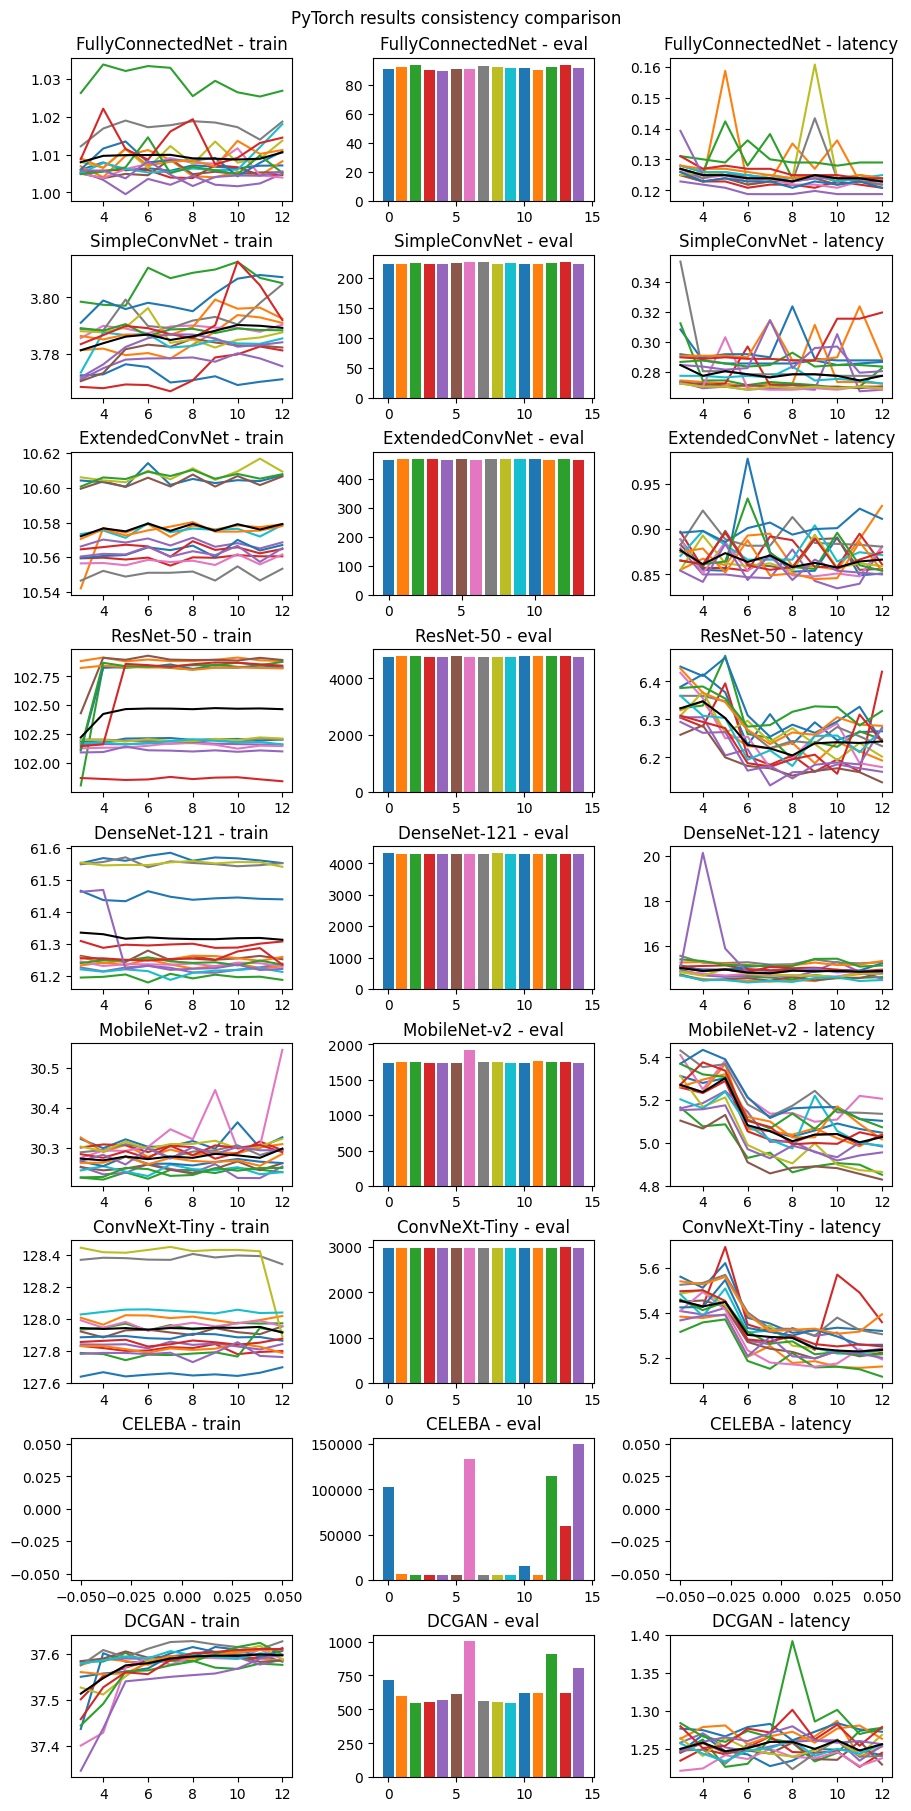

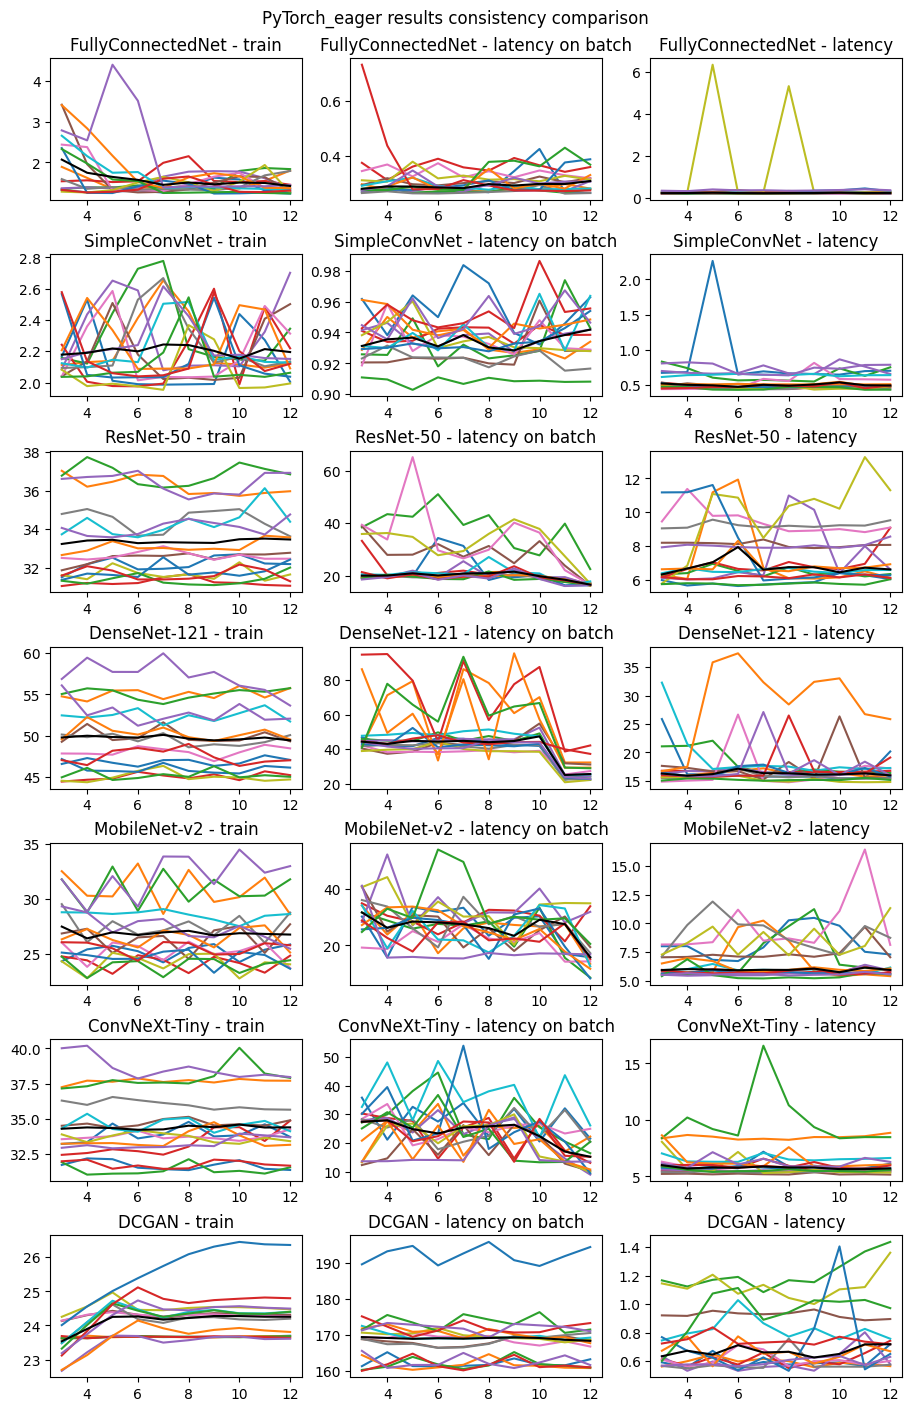

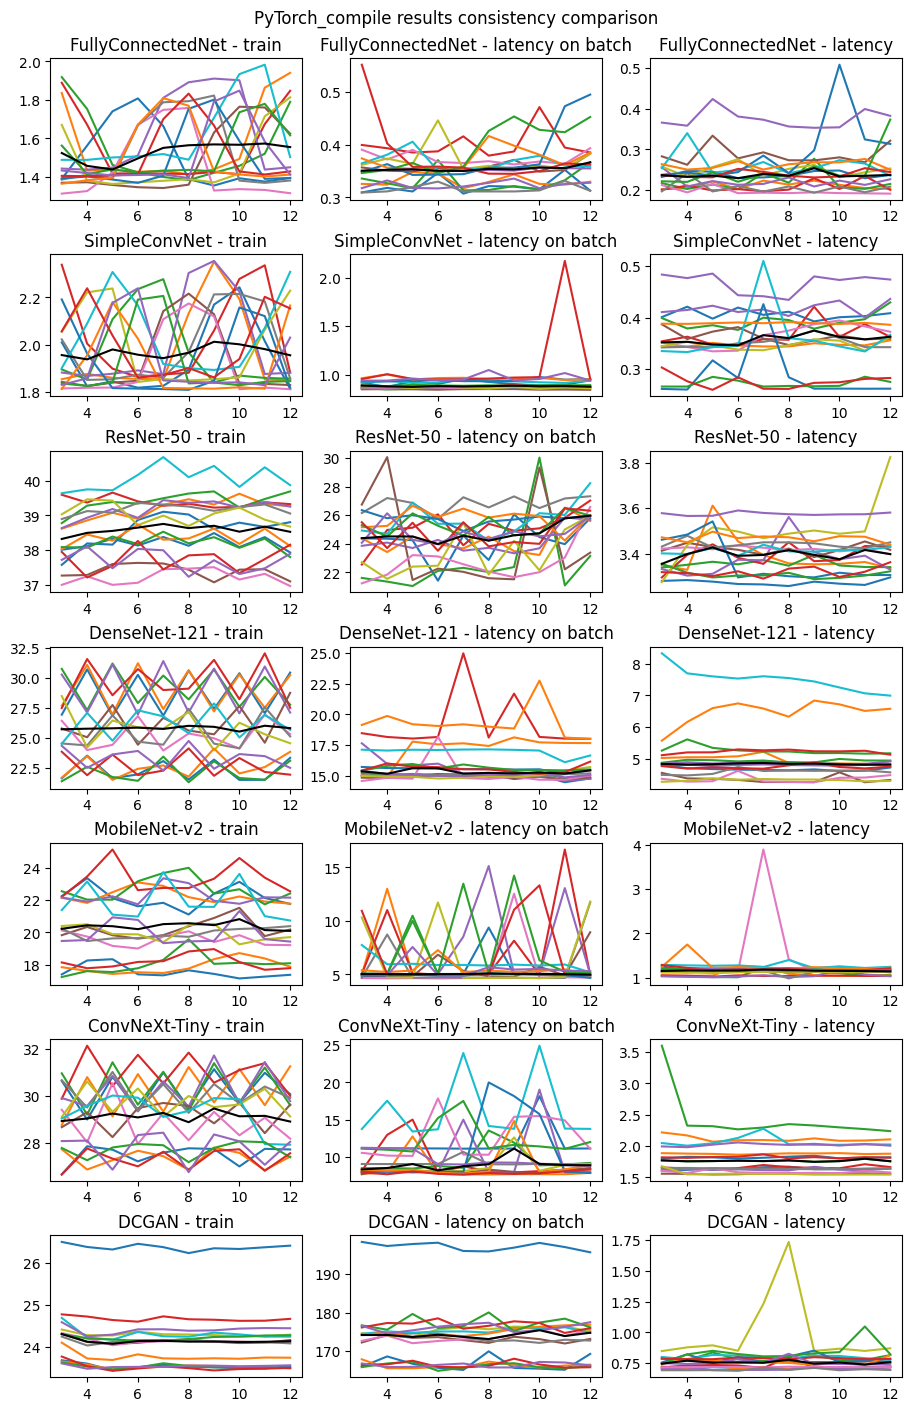

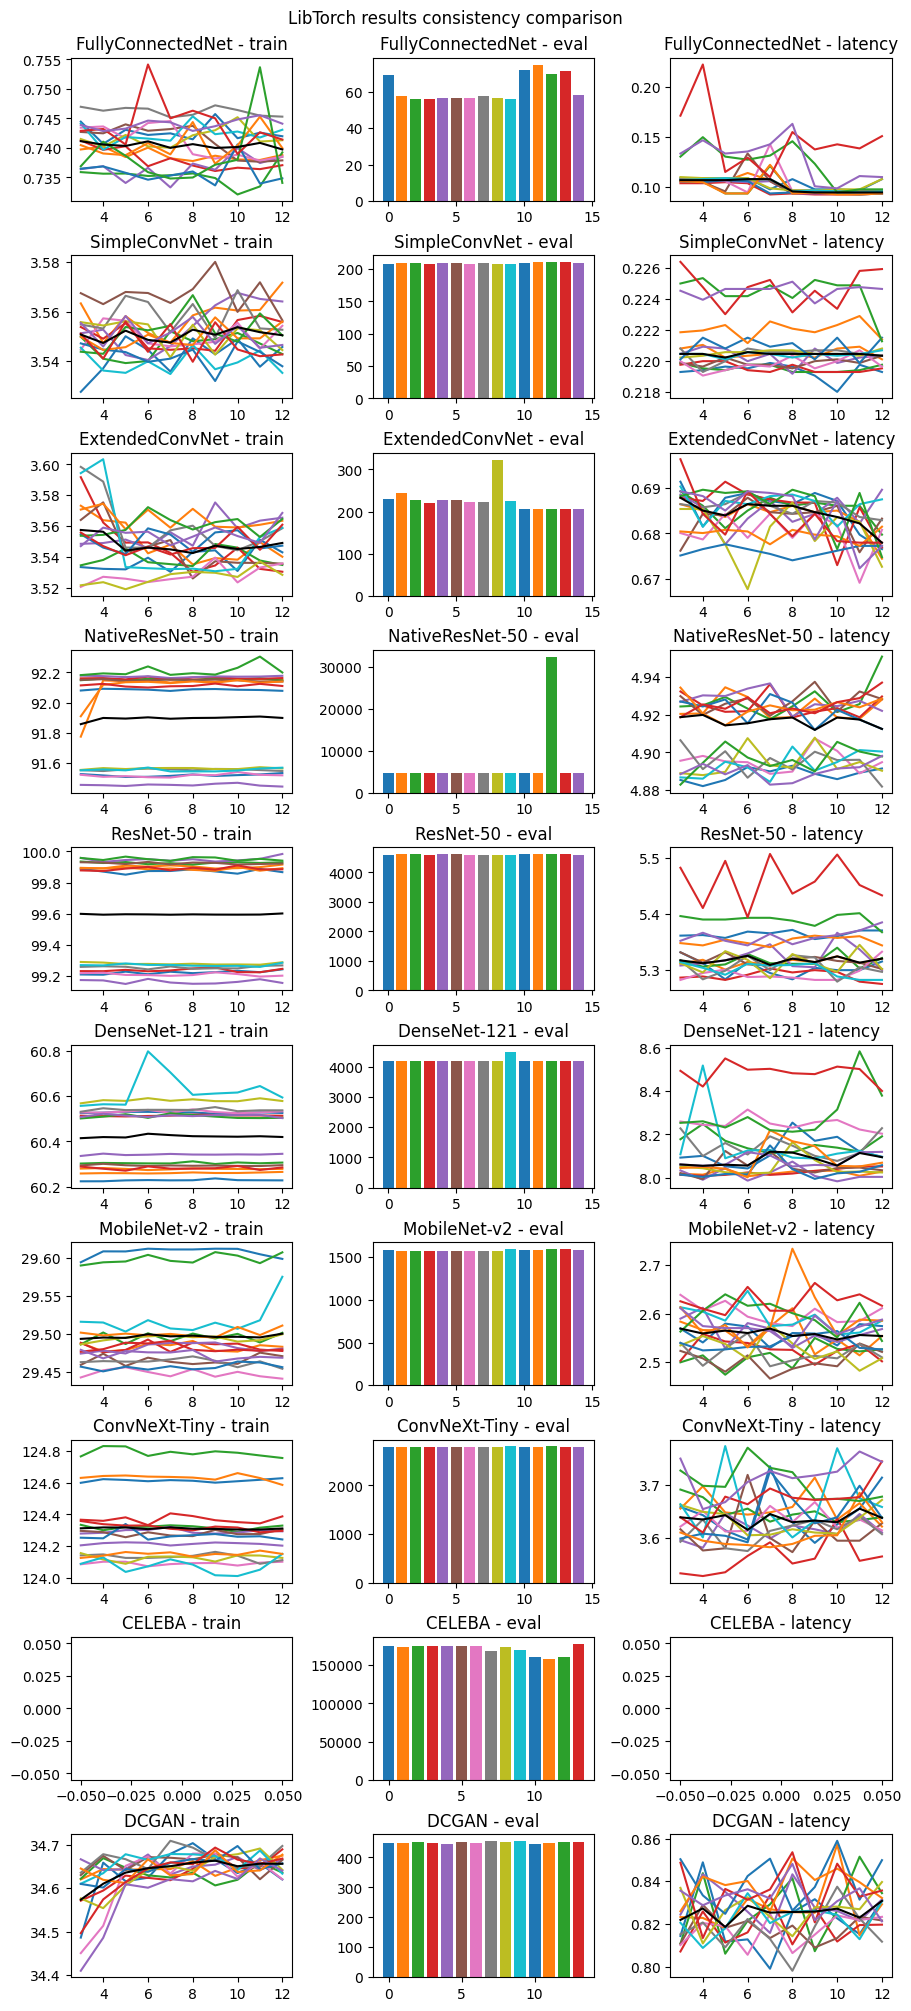

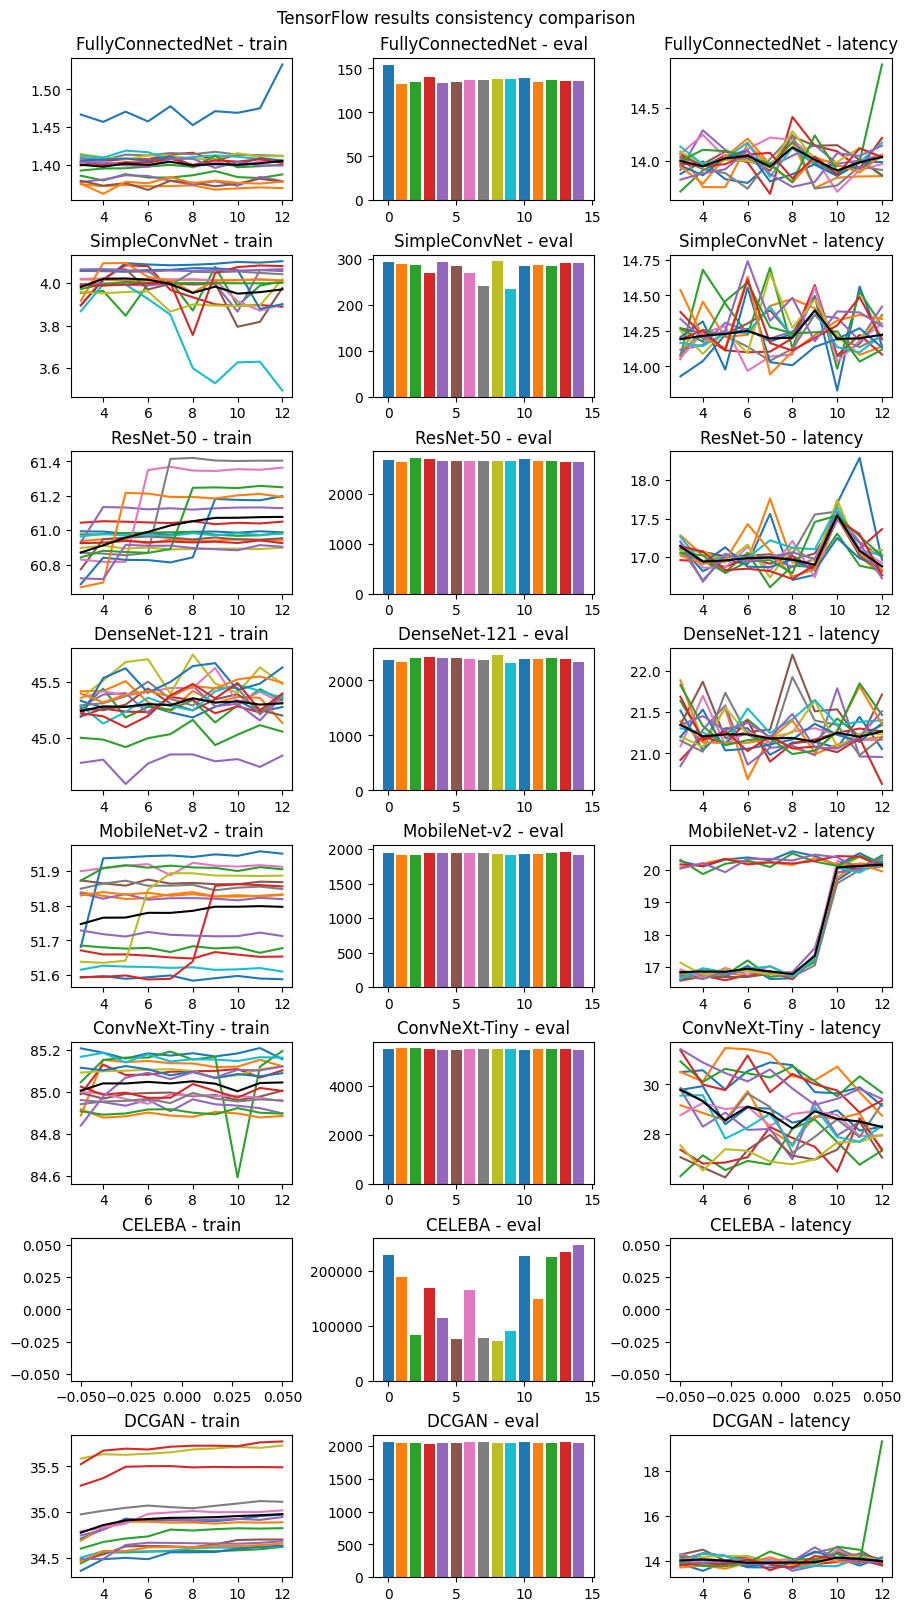

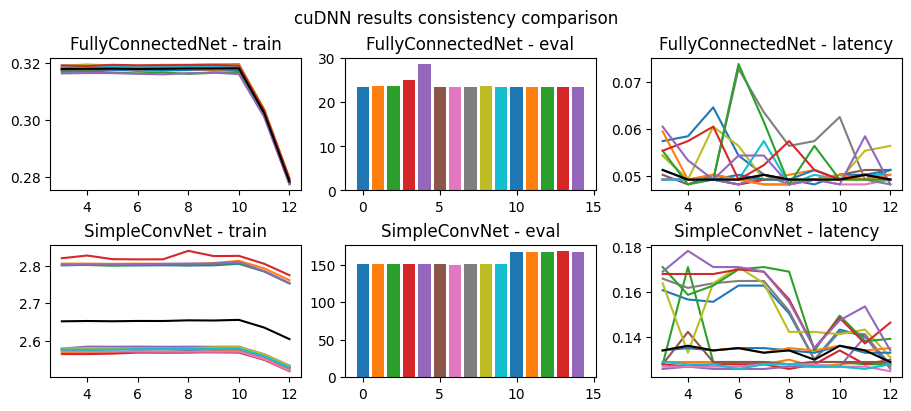

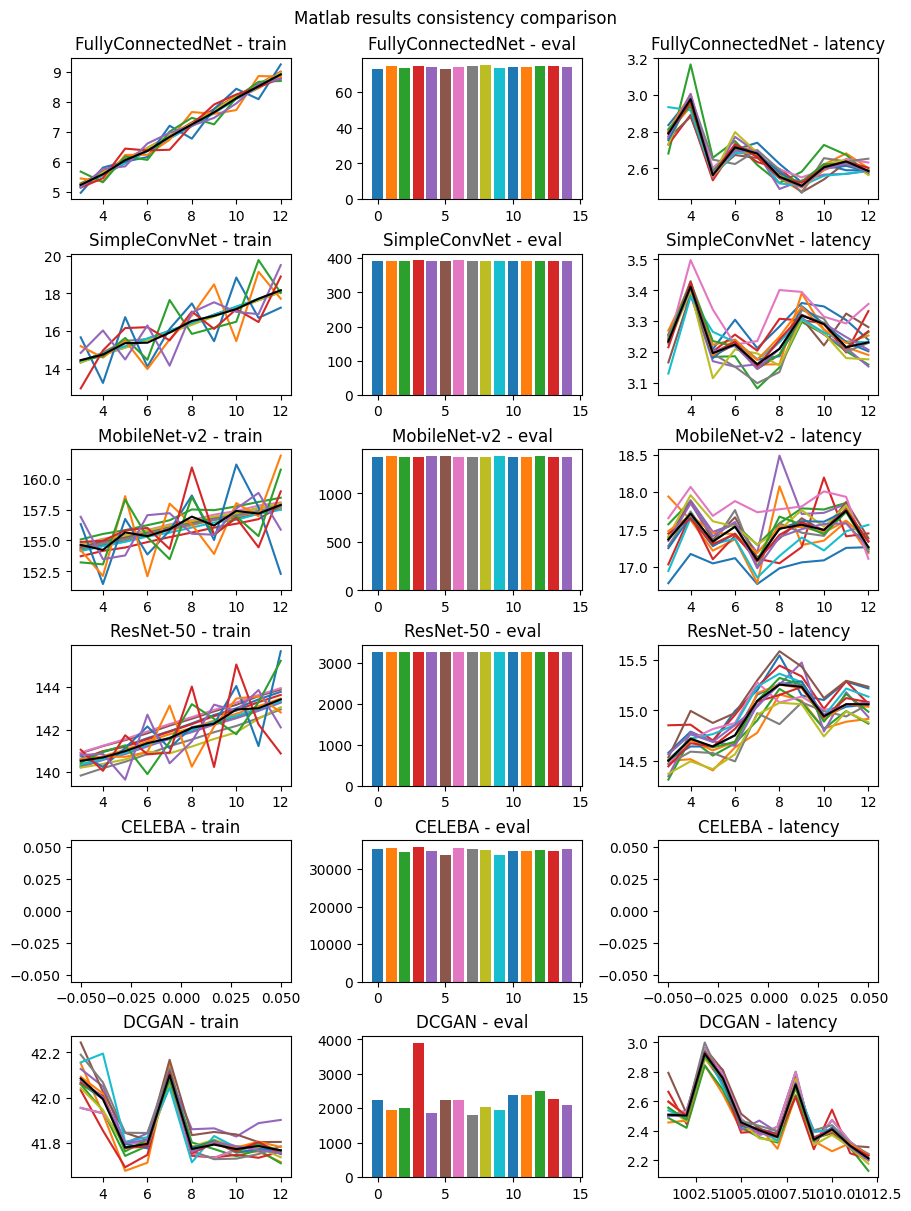

In [38]:
frameworks = ts[0].framework.unique()
for framework in frameworks:
	draw_consistency_comparison(framework, ts, es, ls, t_agg, e_agg, l_agg)

All benchmarks have near perfect consistency, thus there is no meaningful use in result aggregation. BUT I still do it for the CRAFT

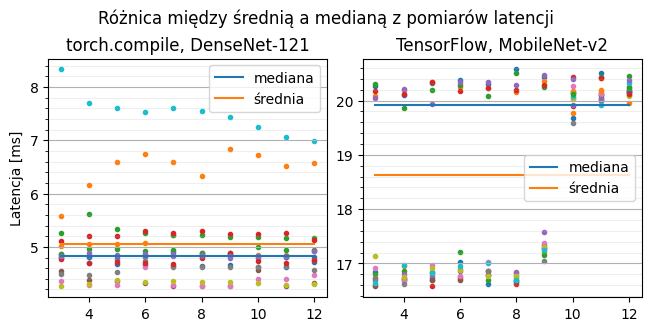

In [82]:
ls_var = [l[(((l.framework == "PyTorch_compile") & (l.model_name == "DenseNet-121")) | ((l.framework == "TensorFlow") & (l.model_name == "MobileNet-v2"))) & (l.phase == "latency")] for l in ls]
# ls_var = [l[(((l.framework == "TensorFlow") & (l.model_name == "ResNet-50")) | ((l.framework == "TensorFlow") & (l.model_name == "MobileNet-v2"))) & (l.phase == "latency")] for l in ls]

_, _, l_agg = mean_aggregate_results(*dfs_c, train_preserve_epoch=True, latency_preserve_epoch=False)

fig, axes = plt.subplots(1, 2, constrained_layout=True)
fig.set_size_inches(6.4, 3.2)
fig.suptitle("Różnica między średnią a medianą z pomiarów latencji")

for i, (model, ax) in enumerate(zip(ls_var[0].model_name.unique(), axes)):
	for l in ls_var:
		l = l[l.model_name == model].reset_index(drop=True)
		ax.scatter(l.epoch, l.elapsed_time, marker=".")

	l_median = l_agg[(l_agg.model_name == model) & (l_agg.phase == "latency") & (l_agg.framework == l.iloc[0, 0])].reset_index(drop=True).loc[0, "elapsed_time_median"]
	l_mean = l_agg[(l_agg.model_name == model) & (l_agg.phase == "latency") & (l_agg.framework == l.iloc[0, 0])].reset_index(drop=True).loc[0, "elapsed_time_mean"]

	median_handle, = ax.plot(l.epoch, [l_median] * 10, color="tab:blue")
	mean_handle, = ax.plot(l.epoch, [l_mean] * 10, color="tab:orange")

	ax.legend(handles=[median_handle, mean_handle], labels=["mediana", "średnia"])
	ax.set_title("torch.compile, DenseNet-121" if i == 0 else "TensorFlow, MobileNet-v2")

	ax.grid(axis="y", which="major", zorder=1)
	ax.minorticks_on()
	ax.tick_params(axis='x', which='minor', bottom=False)
	ax.grid(visible=True, axis="y", which="minor", alpha=0.2, zorder=1)
	if i == 0: ax.set_ylabel("Latencja [ms]")

fig.savefig("../paper/plots/5-1.png")

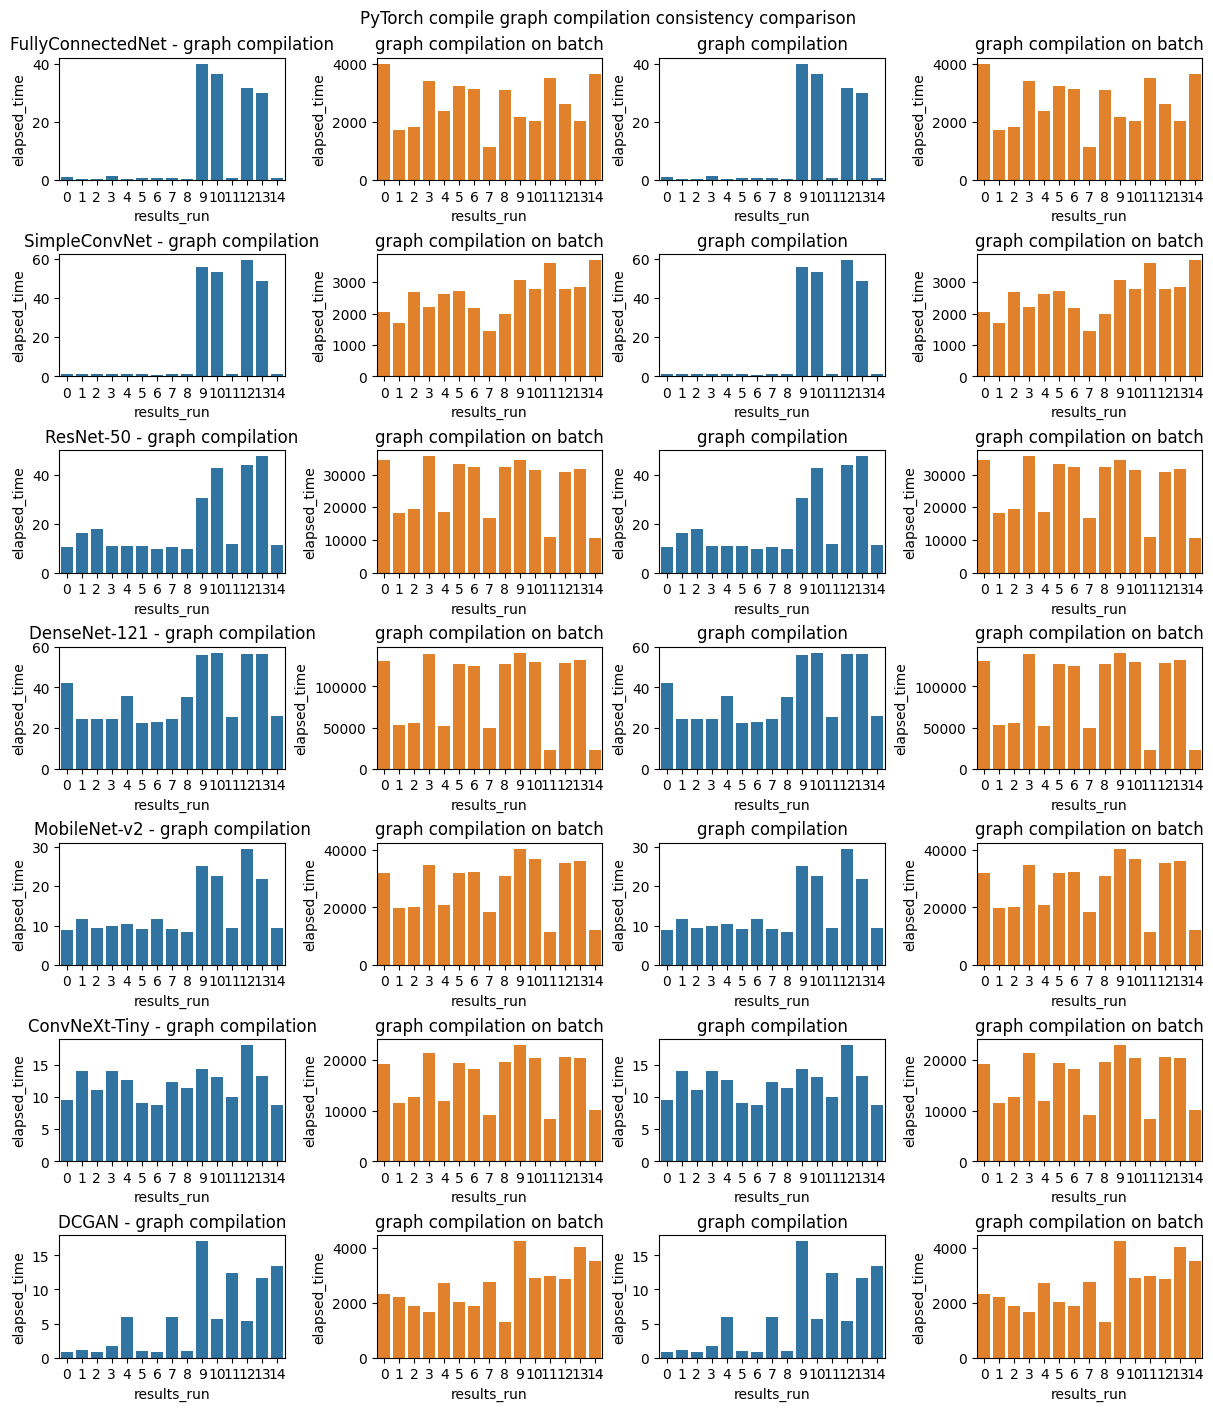

In [42]:
es = list(map(lambda df: df[df.framework.isin(["PyTorch_eager", "PyTorch_compile"])], es))

n_cols = 4
models = flat_map(lambda m: [m] * n_cols, es[0].model_name.unique())
n_models = len(models) // n_cols

fig, axes = plt.subplots(n_models, n_cols, constrained_layout=True)
fig.set_size_inches(3 * n_cols, 2 * n_models)
fig.suptitle(f'PyTorch compile graph compilation consistency comparison')

for idx, (model, ax) in enumerate(zip(models, axes.flatten())):
	if idx % 4 == 0 or idx % 4 == 2:
		es_inner = list(map(lambda df: df[df.framework == "PyTorch_eager"], es))
	else:
		es_inner = list(map(lambda df: df[df.framework == "PyTorch_compile"], es))

	if idx %  2 == 0:
		data = pd.concat([e.assign(results_run=i) for i, e in enumerate(es_inner)])
		data = data[data.model_name == model]
		data = data[data.phase == 'graph_compilation']
		sns.barplot(data=data, x='results_run', y='elapsed_time', ax=ax, color="tab:blue")
		if idx % 4 == 0:
			ax.set_title(f"{model} - graph compilation")
		else:
			ax.set_title(f"graph compilation")

	else:
		data = pd.concat([e.assign(results_run=i) for i, e in enumerate(es_inner)])
		data = data[data.model_name == model]
		data = data[data.phase == 'graph_compilation_batch']
		sns.barplot(data=data, x='results_run', y='elapsed_time', ax=ax, color="tab:orange")
		ax.set_title(f"graph compilation on batch")
	ax.legend([],[], frameon=False)